**What is our task?**

1) We need to define a product which we want to value

2) We calculate the price and the delta plus a trading grid

This means

a) we need to be able to simulate a GM BM

b) we need to be able to simulate the PH behaviour process


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

r=0.04 # Risk Free interest rate
sigma = 0.15 # Volatility

sigma_shares= 0.20
proportion_shares = 0.75
print(sigma_shares*proportion_shares)

0.15000000000000002


**Product Characteristics**

1) We Start with a Single Premium of 1000000

2) We will start at a deferring state, and have the following benefit structures

3) High Water Mark on a **quarterly** ratchet or if higher a 1% geometric increase of the Benefit Base **until age 75, afterwards this guarantee stops**

4) Two types of Insurance a GMDB which is the Benefit base, linealy decresing until age 85

5) A GMWB with 5% conversion rate between 60 and 6% for ages 71 and older, **interpolated in between**

6) **The annuity is paid out 4x a year, ie when a first time utilisation happens at 60.25 the annuity which would be paid is the iterpolated conversation rate times fund value DIVIDED by 4**

**NOTE we implement this by looking at quarters, ie 60 --> quarter 240**


Translating to Quarters
lapserate_Q 0.015349822788181422
r_Q 0.009853406548968824
sigma_Q 0.075


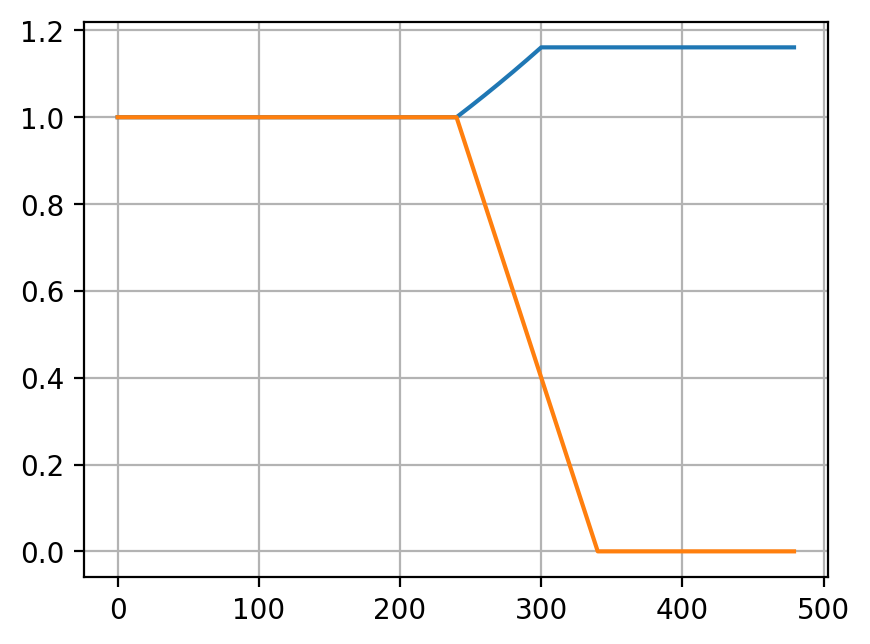

In [2]:
x0 = 60
omega = 120
lapserate = 0.06 # Lapse Rate
EE = 1000000
nrSim = 5000
alpha = 0.01 # Geometric Increase of the Guarantee
i0 = 0 # That is the starting state of our MC
sx = 85
periodspa = 4
print("Translating to Quarters")
x0_Q =x0 * periodspa
omega_Q =omega * periodspa
sx_Q = sx  * periodspa
alpha_Q = (1+alpha)**0.25-1
lapserate_Q = 1.-(1-lapserate)**0.25
print("lapserate_Q",lapserate_Q)
r_Q = (1+r)**.25 -1
print("r_Q",r_Q)
sigma_Q = sigma/(4**.5)
print("sigma_Q",sigma_Q)
uws_Q = np.zeros(omega_Q)
uws_Q[:60*periodspa] = 0.05
uws_Q[70*periodspa:] = 0.06
for i in range(60*periodspa,70*periodspa):
    uws_Q[i] =0.05 +(0.06-0.05)*(i-60*periodspa)/((70-60)*periodspa)

uws_Q *=0.25
guarantee_Q =  np.ones(omega_Q)
for i in range(x0*periodspa+1,omega_Q):
    if i <= 75 *periodspa:
        guarantee_Q[i] = (1+alpha_Q)* guarantee_Q[i-1]
    else:
        guarantee_Q[i] = guarantee_Q[i-1]
leveldeathbenefit_Q =  np.ones(omega_Q)
leveldeathbenefit_Q[85*periodspa:]= 0
for i in range(x0_Q,85*periodspa):
    leveldeathbenefit_Q[i] = (1. - (i-x0_Q)/(sx_Q-x0_Q))
startstate= 4

plt.plot(range(omega_Q),guarantee_Q,range(omega_Q),leveldeathbenefit_Q)
plt.grid(True)

**Now we need to define various things**

1) Mortality

2) Trajectories for GM BM

What do you want to simulate. There are two things either you simulate $S_t$ under $\mathbb{Q}$ or you simulate  $p_t = \frac{S_{t+1}}{S_t}$

$p_t = \exp(X)$ where $X \sim \mathcal{N}(\mu- \frac{\sigma^2}{2},\sigma)$

**Note: This needs to be adjusted for quarterly ratchets**

3) Trajectories for Ultilisation

**Note this needs also to be adjused for quarterly ratchets, ie the utlisation process needs to be adjusted accordingly - how?**




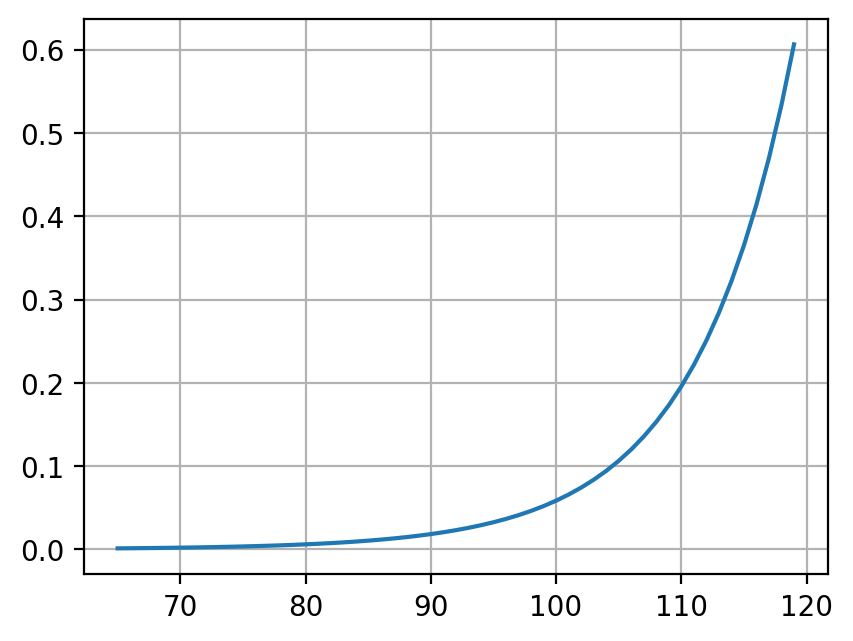

In [3]:
def Qx(gender,x,t,param =[]): # Important this is calibrated with t in calendar years ie today t=2021
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

normaldist = np.random.normal
lognormaldist = np.random.lognormal

def vGenerateTrajectory(mu,sigma,nVectLength):
        return(normaldist(mu,sigma,nVectLength))
    
def vGenerateLNTrajectory(mu,sigma,nVectLength):
        return(lognormaldist(mu,sigma,nVectLength))
    
def vGenerateShareReturnTrajectory(dEquityDrift,dEquityVola,nVectLength):
        return(lognormaldist((dEquityDrift- dEquityVola**2/2.),dEquityVola,nVectLength))

xx = []
yy = []
for i in range(65,120):
    xx.append(i)
    yy.append(Qx(1,i,2020+i))

plt.plot(xx,yy)
plt.grid(True)

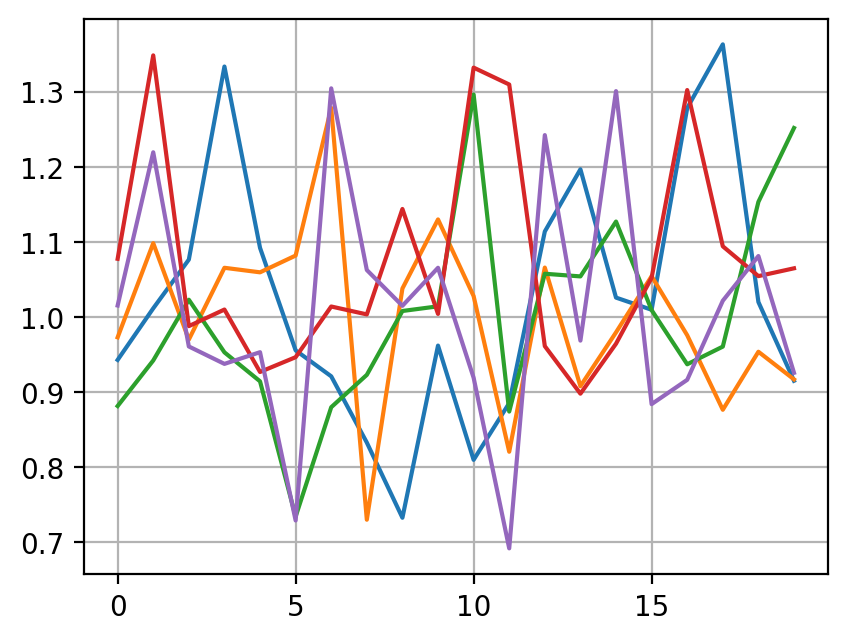

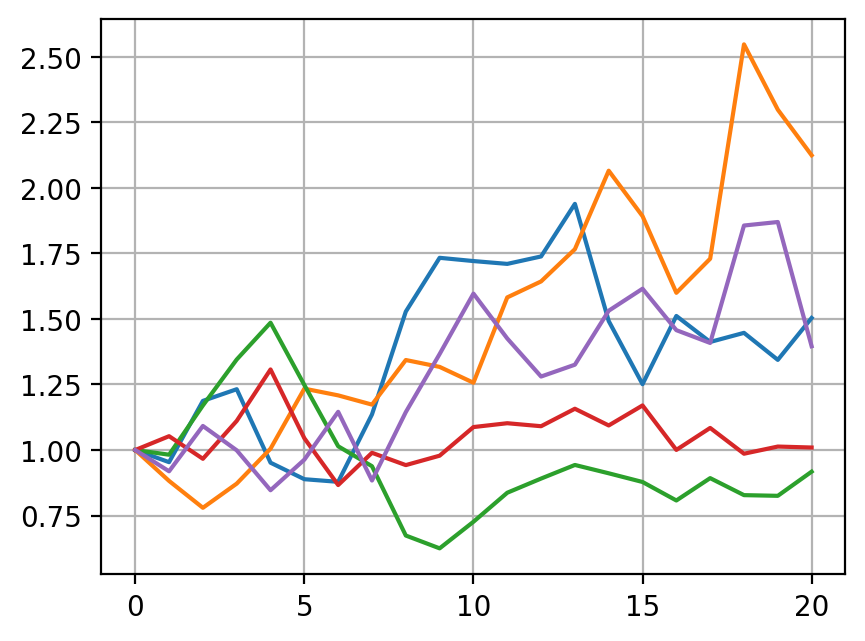

In [4]:
plt.figure(1)
for i in range(5):
    plt.plot(range(20),vGenerateShareReturnTrajectory(r,sigma,20))
plt.grid(True)

plt.figure(2)
for i in range(5):
    s = [1]
    p = vGenerateShareReturnTrajectory(r,sigma,20)
    for k in p:
        s.append(s[-1]*k)
    plt.plot(range(len(s)),s)
plt.grid(True)

**How do we address Utilisation**

Markov Chain

**Note this is the annual utilisation process - how do you need to adjust it?**

In [5]:
a = 0.758
b = 0.724
P= np.array([[0.95, 0.05, 0, 0, 0],[1-a, 0.95*a, 0.05*a,0,0],[0.8*(1-a),0.2*(1-a),0.95*a,0.05*a,0],[0.1*(1-b),0.1*(1-b),0.8*(1-b),b,0],[0.1*(1-b),0.1*(1-b),0.8*(1-b),0,b]])

In [6]:
import scipy.linalg
print(P)
P_Q = sp.linalg.sqrtm(sp.linalg.sqrtm(P))

print(P_Q)

print(P- P_Q.dot(P_Q).dot(P_Q).dot(P_Q))

print("This is approx")

[[0.95   0.05   0.     0.     0.    ]
 [0.242  0.7201 0.0379 0.     0.    ]
 [0.1936 0.0484 0.7201 0.0379 0.    ]
 [0.0276 0.0276 0.2208 0.724  0.    ]
 [0.0276 0.0276 0.2208 0.     0.724 ]]
[[ 9.85829088e-01  1.44340195e-02 -2.71200683e-04  8.09333874e-06
   0.00000000e+00]
 [ 6.88150331e-02  9.19203411e-01  1.22237077e-02 -2.42152009e-04
   0.00000000e+00]
 [ 5.42741105e-02  1.40544323e-02  9.19524345e-01  1.21471119e-02
   0.00000000e+00]
 [ 1.23496445e-03  7.12593248e-03  7.05968944e-02  9.21042209e-01
   0.00000000e+00]
 [ 1.23496445e-03  7.12593248e-03  7.05968944e-02 -1.39038799e-03
   9.22432597e-01]]
[[-2.88657986e-15 -9.71445147e-16 -9.50624441e-16  4.78649848e-17
   0.00000000e+00]
 [-1.72084569e-15 -1.22124533e-15 -6.38378239e-16 -1.35525272e-16
   0.00000000e+00]
 [-1.19348975e-15 -5.41233725e-16 -2.22044605e-16  5.34294831e-16
   0.00000000e+00]
 [-2.01227923e-16 -2.08166817e-17 -3.88578059e-16 -4.66293670e-15
   0.00000000e+00]
 [-1.42247325e-16 -1.28369537e-16 -5.551115

In [7]:
def vGenerateUtiliationTrajectory(StartState,P,nVectLength,nSize=5):
    U = [StartState]
    r = np.random.uniform(0,1,nVectLength-1)
    for rr in r:
        iLocStartState = U[-1]
        dTemp = 0
        for j in range(nSize):
            dTemp += P[iLocStartState,j]
            if dTemp > rr: break
        U.append(j)
    return(U)

def vGenerateAnnuityLevelTrajectory(StartState,P,nVectLength,nSize=5):
    U = vGenerateUtiliationTrajectory(StartState,P,nVectLength,nSize=nSize)
    R = []
    for u in U:
        R.append(1-u/4.)
    return(R)

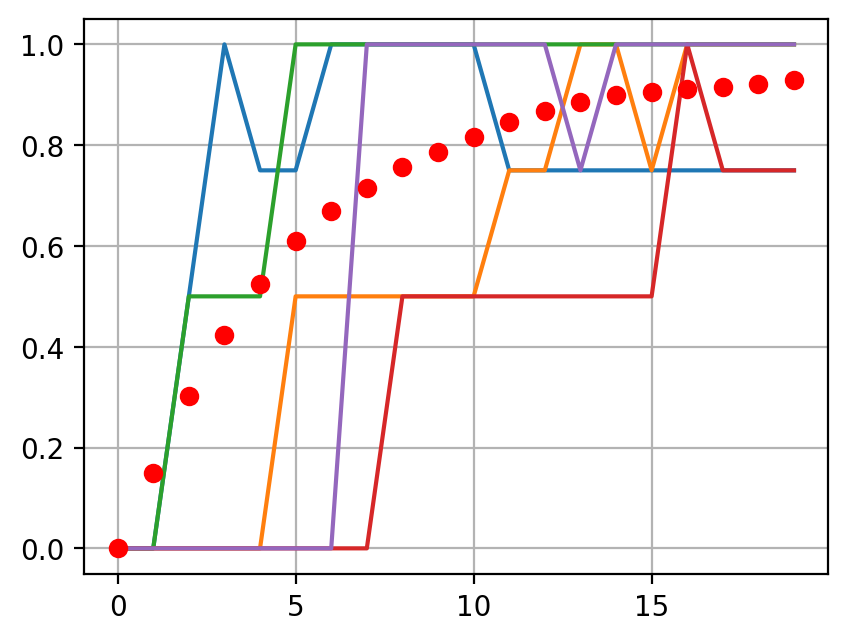

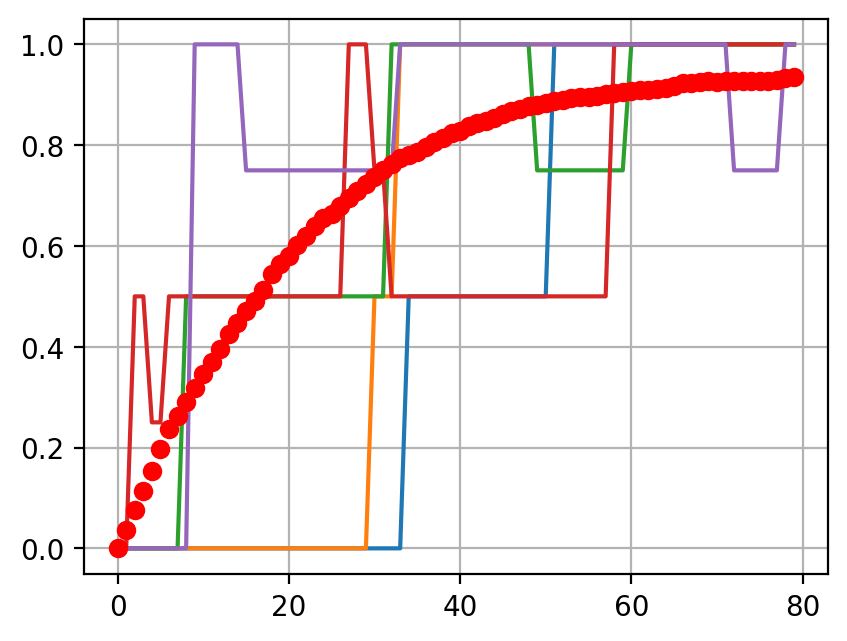

In [8]:
plt.figure(1)
for i in range(5):
    U = vGenerateAnnuityLevelTrajectory(4,P,20)
    plt.plot(range(len(U)),U)
plt.grid(True)

U = np.array(U)
for i in range(1000):
    U += np.array(vGenerateAnnuityLevelTrajectory(4,P,20))
U /= 1001.
plt.plot(range(len(U)),U,"ro")

plt.figure(2)
for i in range(5):
    U = vGenerateAnnuityLevelTrajectory(4,P_Q,80)
    plt.plot(range(len(U)),U)
plt.grid(True)

U = np.array(U)
for i in range(1000):
    U += np.array(vGenerateAnnuityLevelTrajectory(4,P_Q,80))
U /= 1001.
plt.plot(range(len(U)),U,"ro")
    

In [9]:
###### NOTE THE CODE NEEDS TO BE ADJUSTED FOR THE CHANGED TASK

#Product Characteristics**
#1) We Start with a Single Premium of 1000000
#
#2) We will start at a deferring state, and have the following benefit structures
#
#3) High Water Mark on a annual ratchet or if higher a 1% geometric increase of the Benefit Base
#     ---> guarantee
#4) Two types of Insurance a GMDB which is the Benefit base, linealy decresing until age 85 
#     ---> leveldeathbenefit
#
#5) A GMWB with 5% conversion rate between 60 and 70 and 6% for older ages
#.    ---> uws

def PriceVAOneSim(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,gender=0, sx = 0,Periodspa=4):
    nLen = omega -x0 -1 
    p = vGenerateShareReturnTrajectory(r,sigma,nLen)
    R = vGenerateAnnuityLevelTrajectory(startstate,P,nLen)
    bUsingAnnuity = 0
    CFDB = np.zeros(nLen)
    CFWB = np.zeros(nLen)
    BBwoG = BB
    BB0 = BB
    tpx = 1.
    for t in range(nLen):
        x = x0 + t
        qx = Qx(gender,x/Periodspa,2020+t/Periodspa)/Periodspa
        PeopleGettingDB = tpx * qx
        PeopleGettingWB = tpx 
        if R[t] >0 and bUsingAnnuity == 0:
            bUsingAnnuity = uws[t]
        Annuity = BB * bUsingAnnuity * R[t]
        Deathbenefit = leveldeathbenefit[x] * BB
        tpx *= (1-qx)*(1-sx)
        #print(x,t,tpx, qx)
        EEPlus = (EE - Annuity)
        if EEPlus < 0:
            CFWB[t] = -EEPlus * PeopleGettingWB
            EEPlus = 0
        EEPlus *= p[t]
        CFDB[t] = max(0,Deathbenefit - EEPlus) * PeopleGettingDB
        #print(t,Deathbenefit,EEPlus,CFDB[t])
        BBwoG = max(BBwoG, EEPlus)
        BB = max(BBwoG,guarantee[x+1]*BB0)
        EE = EEPlus # Roll forwards funds by a year
    
    pvdb = 0
    pvwb = 0
 
    for t in range(len(CFDB)-1,-1,-1):
        pvdb = (pvdb + CFDB[t])/(1+r)
        pvwb = pvwb/(1+r) + CFWB[t]
    
    return(pvdb,pvwb, CFDB,CFWB)
    
def PriceVAOneAverage(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,NrSim,nChatter = 500, sx=0, bPic=True):
    dVal = 0.
    nLen = omega -x0 -1 
    DB = np.zeros(nLen)
    WB = np.zeros(nLen)
    for i in range(NrSim):
        if nChatter and i % nChatter == 0:
            print("Simulation ",i)
        pvdb,pvwb, CFDB,CFWB = PriceVAOneSim(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,sx=sx)
        dVal += pvdb+pvwb
        DB += CFDB
        WB += CFWB
    DB /= NrSim
    WB /= NrSim
    VAG = DB + WB
    if bPic:
        plt.figure(1)
        plt.plot(range(x0,x0+len(DB)),DB,range(x0,x0+len(WB)),WB,range(x0,x0+len(WB)),VAG)
        plt.grid(True)
    return(dVal/NrSim)


Simulation  0
Simulation  500
Simulation  1000
Simulation  1500
Simulation  2000
Simulation  2500
Simulation  3000
Simulation  3500
Simulation  4000
Simulation  4500


132305.21612462713

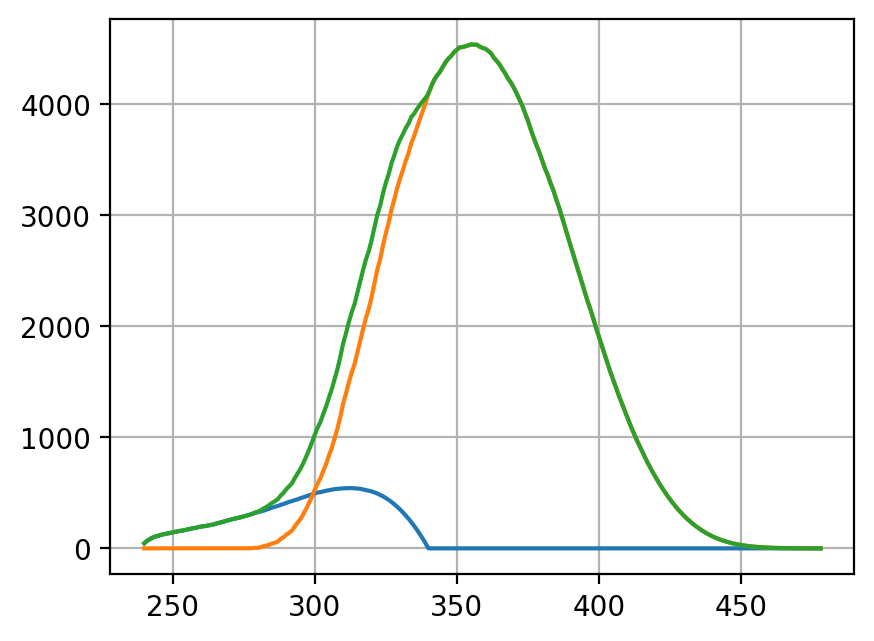

In [10]:
PriceVAOneAverage(x0_Q,omega_Q,EE,EE,r_Q,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,nrSim)

Simulation  0
Simulation  500
Simulation  1000
Simulation  1500
Simulation  2000
Simulation  2500
Simulation  3000
Simulation  3500
Simulation  4000
Simulation  4500
Simulation  0
Simulation  500
Simulation  1000
Simulation  1500
Simulation  2000
Simulation  2500
Simulation  3000
Simulation  3500
Simulation  4000
Simulation  4500
Additional Reserve needed from 30514.6 to 37423.7 is 6909.1


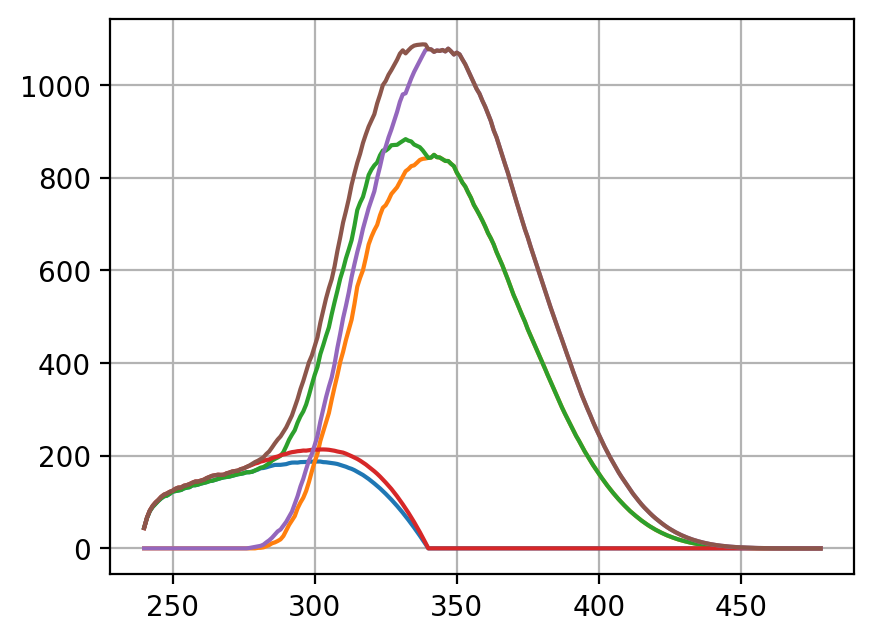

In [11]:
a= PriceVAOneAverage(x0_Q,omega_Q,EE,EE,r_Q,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,nrSim, sx = lapserate_Q)

b = PriceVAOneAverage(x0_Q,omega_Q,EE,EE,r_Q,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,nrSim, sx = 1- (1-0.05)**0.25)

print("Additional Reserve needed from %.1f to %.1f is %.1f"%(a,b,b-a))

Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500
Simulation  0
Simulation  2500


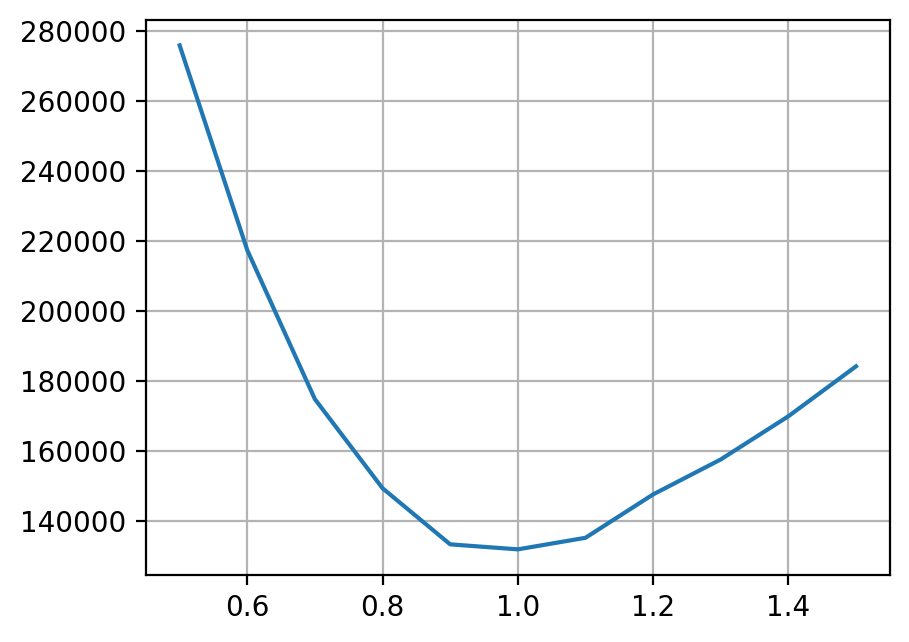

In [12]:
SLevel = [0.5,0.6,0.7,.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
Pi =[]
for s in SLevel:
    Pi.append(PriceVAOneAverage(x0_Q,omega_Q,s*EE,EE,r_Q,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,int(nrSim),bPic=False,nChatter = 2500))
    
plt.figure(1)
plt.plot(SLevel,Pi)
plt.grid(True)

In [13]:
SLevel = [0.5,0.6,0.7,.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
RLevel = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]
PiMat = np.zeros([len(SLevel),len(RLevel)])
for s in range(len(SLevel)):
    print("Level ",s)
    for i in range(len(RLevel)):
        PiMat[s,i] = PriceVAOneAverage(x0_Q,omega_Q,SLevel[s]*EE,EE,(1+RLevel[i])**0.25-1,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,500,bPic=False,nChatter = 0)

print("Calculated")

Level  0
Level  1
Level  2
Level  3
Level  4
Level  5
Level  6
Level  7
Level  8
Level  9
Level  10
Calculated


<Figure size 480x360 with 0 Axes>

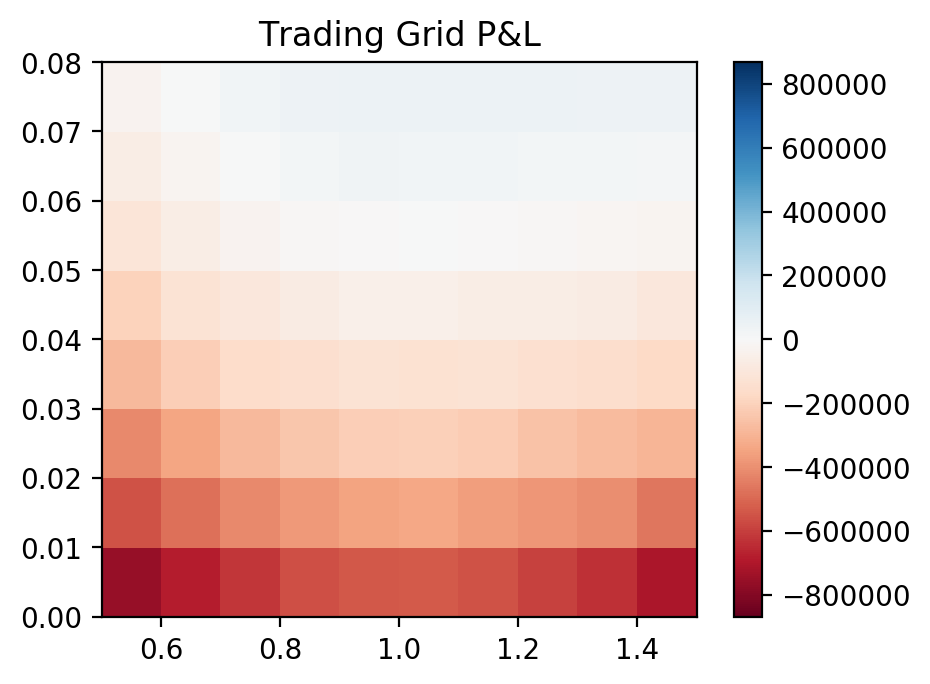

In [14]:
Z = -np.transpose(PiMat[:, :]) + PiMat[5,5]
plt.figure(1)
z_min, z_max = -np.abs(PiMat).max(), np.abs(PiMat).max()
X, Y = np.meshgrid(SLevel, RLevel)
fig, ax = plt.subplots()
#print(X)
#print(Y)
#print(Z)
c = ax.pcolormesh(X, Y, Z, cmap='RdBu', vmin=z_min, vmax=z_max)
#c = ax.imshow(Z, cmap='RdBu', vmin=z_min, vmax=z_max,interpolation = 'bicubic')
ax.set_title("Trading Grid P&L")
# set the limits of the plot to the limits of the data
ax.axis([min(SLevel), max(SLevel), min(RLevel), max(RLevel)])
fig.colorbar(c, ax=ax)


[[ 9.85829088e-01  1.44340195e-02 -2.71200683e-04  8.09333874e-06
   0.00000000e+00]
 [ 6.88150331e-02  9.19203411e-01  1.22237077e-02 -2.42152009e-04
   0.00000000e+00]
 [ 5.42741105e-02  1.40544323e-02  9.19524345e-01  1.21471119e-02
   0.00000000e+00]
 [ 1.23496445e-03  7.12593248e-03  7.05968944e-02  9.21042209e-01
   0.00000000e+00]
 [ 1.23496445e-03  7.12593248e-03  7.05968944e-02 -1.39038799e-03
   9.22432597e-01]]

 [[ 0.00123496  0.00712593  0.07059689 -0.00139039  0.9224326 ]]

 [[ 0.00667687  0.01412349  0.13002505 -0.00170731  0.8508819 ]]
0.0071259324759086005


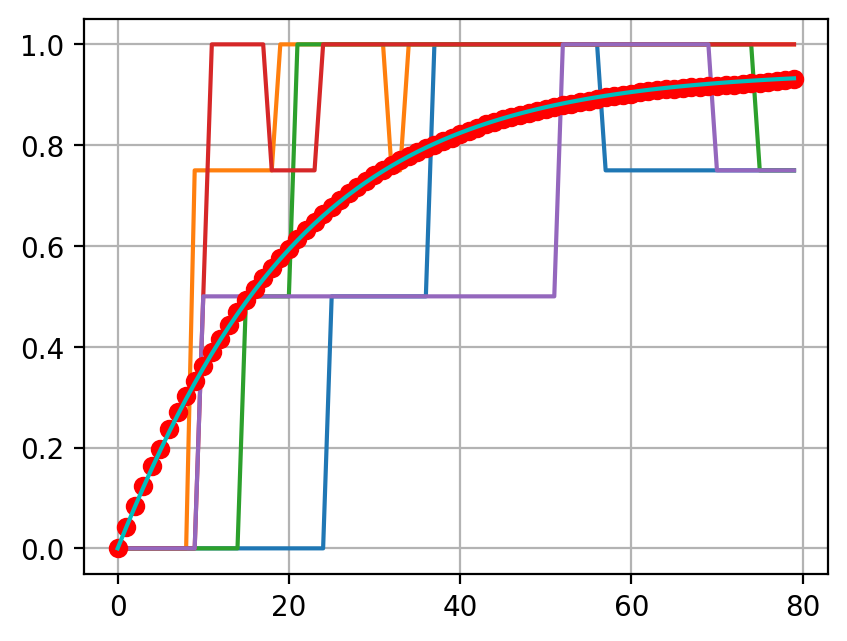

In [15]:
print(P_Q)
PP = np.mat(P_Q)
SD = np.transpose(np.mat([[0],[0],[0],[0],[1]]))
print("\n",SD*PP)
SD = SD*PP
print("\n",SD*PP)

print(SD[0,1])


plt.figure(1)
for i in range(5):
    U = vGenerateAnnuityLevelTrajectory(4,P_Q,80)
    plt.plot(range(len(U)),U)
plt.grid(True)

U = np.array(U)
for i in range(10000):
    U += np.array(vGenerateAnnuityLevelTrajectory(4,P_Q,80))
U /= 10001.
plt.plot(range(len(U)),U,"ro")

SD = np.transpose(np.mat([[0],[0],[0],[0],[1]]))

U2 = []
for j in range(len(U)):
    temp = 0
    for k in range(5):
        temp += (1 - k*.25) * SD[0,k]
    U2.append(temp)
    SD = SD*PP
    
plt.plot(range(len(U)),U2,"c-")

**Question - this is important for the examp and is expected to be done**

What happens if we have no ratchet guarantee and no geometric increase in the benefit base?

Compare your resuly with a traditional annuity with the respective interest rate in the concrete case 4% where the annuity behaves with the same utilisation - ie the conversatio rate is picked at the first time utilisation happens

To make things simpler assume an annual annuity

**What do you remark and why?**

\begin{eqnarray*}
GMWB = \mathbb{E}[\sum_{k}(1+r)^{-k} \times G(k,\omega)]
\end{eqnarray*}

In [16]:
def PriceVAOneSim_aex(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,gender=0, sx = 0,Periodspa=4):
    nLen = omega -x0 -1 
    R = vGenerateAnnuityLevelTrajectory(startstate,P,nLen)
    bUsingAnnuity = 0
    CFDB = np.zeros(nLen)
    CFWB = np.zeros(nLen)
    BBwoG = BB
    BB0 = BB
    tpx = 1.
    for t in range(nLen):
        x = x0 + t
        qx = Qx(gender,x/Periodspa,2020+t/Periodspa)/Periodspa
        PeopleGettingDB = tpx * qx
        PeopleGettingWB = tpx 
        if R[t] >0 and bUsingAnnuity == 0:
            bUsingAnnuity = uws[t]
        Annuity = BB * bUsingAnnuity * R[t]
        Deathbenefit = 0
        tpx *= (1-qx)*(1-sx)
        #print(x,t,tpx, qx)
        EEPlus = EE 
        CFWB[t] = Annuity * PeopleGettingWB
        EEPlus *= 1
        CFDB[t] = 0
        #print(t,Deathbenefit,EEPlus,CFDB[t])
        BB = EE
        EE = EEPlus # Roll forwards funds by a year
    
    pvdb = 0
    pvwb = 0
 
    for t in range(len(CFDB)-1,-1,-1):
        pvdb = (pvdb + CFDB[t])/(1+r)
        pvwb = pvwb/(1+r) + CFWB[t]
    
    return(pvdb,pvwb, CFDB,CFWB)
    
def PriceVAOneAverage_aex(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,NrSim,nChatter = 500, sx=0, bPic=True):
    dVal = 0.
    nLen = omega -x0 -1 
    DB = np.zeros(nLen)
    WB = np.zeros(nLen)
    for i in range(NrSim):
        if nChatter and i % nChatter == 0:
            print("Simulation ",i)
        pvdb,pvwb, CFDB,CFWB = PriceVAOneSim_aex(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,sx=sx)
        dVal += pvdb+pvwb
        DB += CFDB
        WB += CFWB
    DB /= NrSim
    WB /= NrSim
    VAG = DB + WB
    if bPic:
        plt.figure(1)
        plt.plot(range(x0,x0+len(DB)),DB,range(x0,x0+len(WB)),WB,range(x0,x0+len(WB)),VAG)
        plt.grid(True)
    return(dVal/NrSim)

Simulation  0
Simulation  10000
Simulation  20000
Simulation  30000
Simulation  40000
541856.1889346614


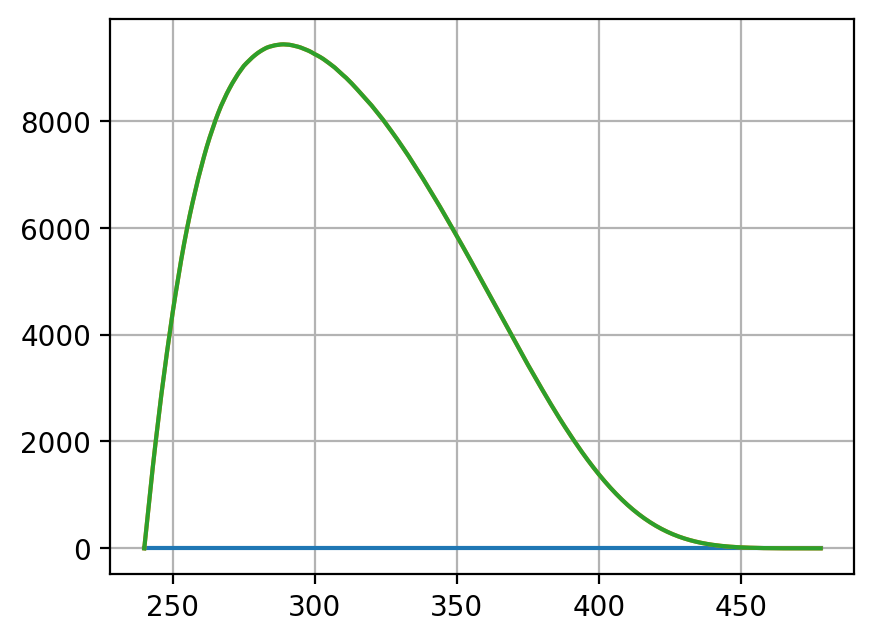

In [17]:
nrSim2 = 10* nrSim
eeaex =PriceVAOneAverage_aex(x0_Q,omega_Q,EE,EE,r_Q,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,nrSim2,nChatter = 10000)
print(eeaex)

In [18]:
def PriceVAOneSimMod(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,gender=0, sx = 0,Periodspa=4):
    nLen = omega -x0 -1 
    p = vGenerateShareReturnTrajectory(r,sigma,nLen)
    R = vGenerateAnnuityLevelTrajectory(startstate,P,nLen)
    bUsingAnnuity = 0
    CFDB = np.zeros(nLen)
    CFWB = np.zeros(nLen)
    BBwoG = BB
    BB0 = BB
    tpx = 1.
    for t in range(nLen):
        x = x0 + t
        qx = Qx(gender,x/Periodspa,2020+t/Periodspa)/Periodspa
        PeopleGettingDB = tpx * qx
        PeopleGettingWB = tpx 
        if R[t] >0 and bUsingAnnuity == 0:
            bUsingAnnuity = uws[t]
        Annuity = BB * bUsingAnnuity * R[t]
        Deathbenefit = 0
        tpx *= (1-qx)*(1-sx)
        #print(x,t,tpx, qx)
        EEPlus = (EE - Annuity)
        if EEPlus < 0:
            CFWB[t] = -EEPlus * PeopleGettingWB
            EEPlus = 0
        EEPlus *= p[t]
        CFDB[t] = -EE * PeopleGettingDB
        #print(t,Deathbenefit,EEPlus,CFDB[t])
        EE = EEPlus # Roll forwards funds by a year
    
    pvdb = 0
    pvwb = 0
 
    for t in range(len(CFDB)-1,-1,-1):
        pvdb = (pvdb + CFDB[t])/(1+r)
        pvwb = pvwb/(1+r) + CFWB[t]
    
    return(pvdb,pvwb, CFDB,CFWB)
    
def PriceVAOneAverageMod(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,NrSim,nChatter = 500, sx=0, bPic=True):
    dVal = 0.
    nLen = omega -x0 -1 
    DB = np.zeros(nLen)
    WB = np.zeros(nLen)
    for i in range(NrSim):
        if nChatter and i % nChatter == 0:
            print("Simulation ",i)
        pvdb,pvwb, CFDB,CFWB = PriceVAOneSimMod(x0,omega,EE,BB,r,sigma,startstate,P,guarantee,leveldeathbenefit,uws,sx=sx)
        dVal += pvdb+pvwb
        DB += CFDB
        WB += CFWB
    DB /= NrSim
    WB /= NrSim
    VAG = DB + WB
    if bPic:
        plt.figure(1)
        plt.plot(range(x0,x0+len(DB)),DB,range(x0,x0+len(WB)),WB,range(x0,x0+len(WB)),VAG)
        plt.grid(True)
    return(dVal/NrSim)

Simulation  0
Simulation  10000
Simulation  20000
Simulation  30000
Simulation  40000
Simulation  50000
Simulation  60000
Simulation  70000
Simulation  80000
Simulation  90000
Simulation  100000
Simulation  110000
Simulation  120000
Simulation  130000
Simulation  140000
Simulation  150000
Simulation  160000
Simulation  170000
Simulation  180000
Simulation  190000
-458998.02555334463 541001.9744466554 541856.1889346614


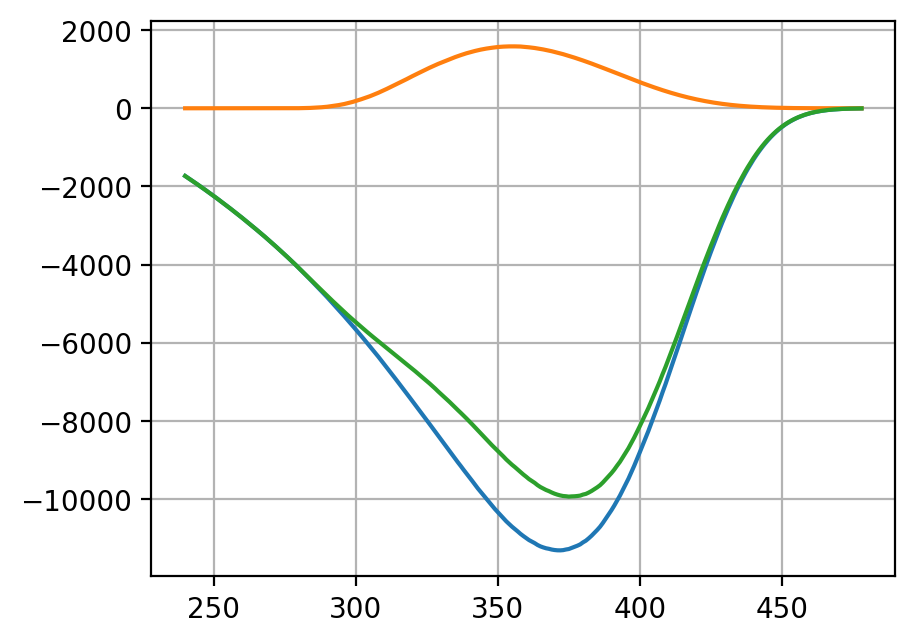

In [19]:
ee = PriceVAOneAverageMod(x0_Q,omega_Q,EE,EE,r_Q,sigma_Q,startstate,P_Q,guarantee_Q,leveldeathbenefit_Q,uws_Q,4*nrSim2,nChatter = 10000)

print(ee, EE+ee, eeaex)